In [1]:
import os
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    utils,
    layers,
    models,
    metrics,
    losses,
    optimizers,
    callbacks
)

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import datetime
import absl.logging

2024-09-29 19:20:15.861990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
def display_original_and_reconstructed(original_images, reconstructed_images, n=5, fig_size=(10, 5)):
    """
    Displays a grid of original images with their reconstructed versions.
    
    original_images: np.array
        Array of original images.
    reconstructed_images: np.array
        Array of reconstructed images.
    n: int, optional (default=5)
        Number of images to display.
    fig_size: tuple, optional (default=(10, 5))
        Size of the figure for displaying images.
    """
    # Choose random indices to display
    indices = np.random.choice(original_images.shape[0], n, replace=False)
    
    # Set up the figure
    plt.figure(figsize=fig_size)
    
    for i, idx in enumerate(indices):
        # Display original image (on the top)
        plt.subplot(2, n, i + 1)
        plt.imshow(original_images[idx].squeeze(), cmap='gray' if original_images.shape[-1] == 1 else None)
        plt.title("Original")
        plt.axis('off')
        
        # Display reconstructed image (below the original)
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[idx].squeeze(), cmap='gray' if reconstructed_images.shape[-1] == 1 else None)
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
def preprocess(img):
    '''
    The original data is scaled in the range [0, 255] to denote the pixel intensity, which we rescale to the range [0, 1]
    '''
    img = tf.cast(img, 'float32') / 255.0
    return img

def sample_batch(dataset):
    # dataset.take(1) - get one batch of data from dataset
    # returns single batch with all elements in it
    batch = dataset.take(1).get_single_element()

    if isinstance(batch, tuple):
        batch = batch[0]

    return batch.numpy()

def display_img(images, n=10, fig_size=(20,3), c_map='gray_r', as_type='float32', save_to=None):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images +1.0) /2.0

    plt.figure(figsize=fig_size)
    for i in range(n):
        _=plt.subplot(1,n,i+1)
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')

    if save_to:
        plt.savefig(save_to)
        print(f'Images saved to {save_to}')

    plt.show()



In [4]:
def download_file_from_google_drive(file_id, file_path):
    url = "https://docs.google.com/uc?export=download&confirm=1"
    session = requests.Session()

    # Получаем подтверждение для скачивания большого файла
    response = session.get(url, params={'id': file_id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(url, params=params, stream=True)

    save_response_content(response, file_path)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, file_path):
    CHUNK_SIZE = 32768

    # Получаем размер файла
    total_size = int(response.headers.get('content-length', 0))

    # Сохраняем файл с прогресс-баром
    with open(file_path, "wb") as f, tqdm(
        desc=f"Downloading {file_path}",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # фильтруем данные, которые пустые
                f.write(chunk)
                bar.update(len(chunk))

In [46]:
def get_vector_from_label(data,vae,embeding_dim,label):
    current_sum_pos= np.zeros(shape=embeding_dim, dtype='float32')
    current_n_pos= 0
    current_mean_pos= np.zeros(shape=embeding_dim, dtype='float32')

    current_sum_neg= np.zeros(shape=embeding_dim, dtype='float32')
    current_n_neg= 0
    current_mean_neg= np.zeros(shape=embeding_dim, dtype='float32')

    current_vector= np.zeros(shape=embeding_dim, dtype='float32')
    current_dist=0

    print(f'label: {label}')
    print('images: pos move: neg move: distance: 𝛥 distance')

    while current_n_pos < 10000:
        batch= list(data.take(1).get_single_element())
        img= batch[0]
        attribute=batch[1]

        _,_,z= vae.encoder.predict(np.array(img), verbose=0)

        z_pos= z[attribute == 1]
        z_neg= z[attribute == -1]

        if len(z_pos) > 0:
            current_sum_pos= current_sum_pos + np.sum(z_pos, axis=0)
            current_n_pos += len(z_pos)
            new_mean_pos= current_sum_pos / current_n_pos
            movement_pos= np.linalg.norm(new_mean_pos - current_mean_pos)

        if len(z_neg) > 0:
            current_sum_neg= current_sum_neg + np.sum(z_neg, axis=0)
            current_n_neg += len(z_neg)
            new_mean_neg= current_sum_neg / current_n_neg
            movement_neg= np.linalg.norm(new_mean_neg-current_mean_neg)

        current_vector= new_mean_pos - new_mean_neg
        new_dist= np.linalg.norm(current_vector)
        dist_change=new_dist-current_dist
        print(f'{current_n_pos}    : {np.round(movement_pos, 3)}    : {np.round(movement_neg, 3)}    : {np.round(new_dist, 3)}    : {np.round(dist_change,3)}')

        current_mean_pos= np.copy(new_mean_pos)
        current_mean_neg= np.copy(new_mean_neg)
        current_dist= np.copy(new_dist)

        if np.sum([movement_pos,movement_neg]) < 0.08:
            current_vector= current_vector / current_dist
            print(f'Found the {label} vector')

            break

    return current_vector

def add_vector_to_images(data,vae,feature_vec):
    n_to_show= 5
    factors= [-4,-3,-2,-1,0,1,2,3,4]

    example_batch=list(data.take(1).get_single_element())
    example_images= example_batch[0]

    _,_,z_points= vae.encoder.predict(example_images,verbose=0)

    fig= plt.figure(figsize=(18,10))
    counter= 1

    for i in range(n_to_show):
        img= example_images[i]
        sub= fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')
        sub.imshow(img)
        counter+=1

        for factor in factors:
            changed_z_point= z_points[i] + feature_vec * factor
            changed_image= vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub= fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(changed_image)
            counter+=1

    plt.show()


def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

# Download CelebA Dataset

[About CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

In [6]:
# Create the destination folder
dataset_path = Path("./celebA")

if not dataset_path.exists():
    
    os.makedirs(dataset_path, exist_ok=True)    
    
    # URL for CelebA dataset (aligned and cropped images)
    url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"
    output = os.path.join(dataset_path, "img_align_celeba.zip")
    
    # Downloading with progress bar
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(output, 'wb') as file, tqdm(
        desc=output,
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            bar.update(len(data))
            file.write(data)
    
    # Extracting the dataset
    
    with zipfile.ZipFile(output, "r") as zip_ref:
        zip_ref.extractall(dataset_path)
        
    print(f"Downloaded and extracted CelebA dataset to: {dataset_path}")
else:
    print(f'Folder "./{dataset_path}" already exists, no action needed')

Folder "./celebA" already exists, no action needed


# Prepare data

We will use the Keras function image_dataset_from_directory to create a TensorFlow Dataset pointed at the directory where the images are stored

In [7]:
%%time

# ~7 min wall time
if 'train_data' not in globals():
    train_data = utils.image_dataset_from_directory(
        './celebA/img_align_celeba',
        labels=None,
        color_mode='rgb',
        image_size=(32,32),
        batch_size=128,
        shuffle=True,
        seed=42,
        interpolation='bilinear' # this option helps us to save quality after resizing
    )
    
    train = train_data.map(lambda x: preprocess(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_sample = sample_batch(train)
else:
    print(f'train_data has been already initialized, no action needed.')

Found 202599 files.


2024-09-29 19:27:42.878088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 19:27:42.908276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 19:27:42.908318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 19:27:42.910562: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29 19:27:42.910596: I external/local_xla/xla/stream_executor

Cause: could not parse the source code of <function <lambda> at 0x7f2f74a4dc60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f2f74a4dc60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 6.39 s, sys: 12.7 s, total: 19.1 s
Wall time: 7min 25s


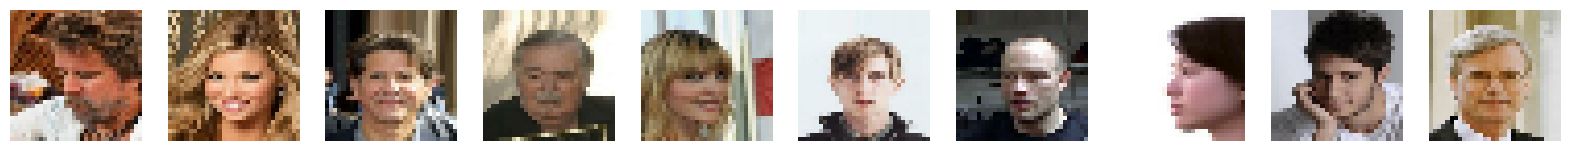

In [8]:
display_img(train_sample)

# BUILD MODEL

## ENCODER

The VAE encoder will take each input image and only needs to map that each input to:
1. z_mean: a mean vector and
2. z_log_var: a variance vector

and does not need to worry about covariance between these 2 vectors dimensions as variational autoencoders assume that there is no correlation between dimensions in the latent space.
Together these two vectors define a multivariate normal distribution in the latent space.

To sample a point z from the distribution defined by values above we can use following equation:
``` python
z = z_mean + z_sigma * epsilon
```
where
``` python
z_sigma = exp(z_log_var * 0.5)
epsilon ~ N(0,I)
```
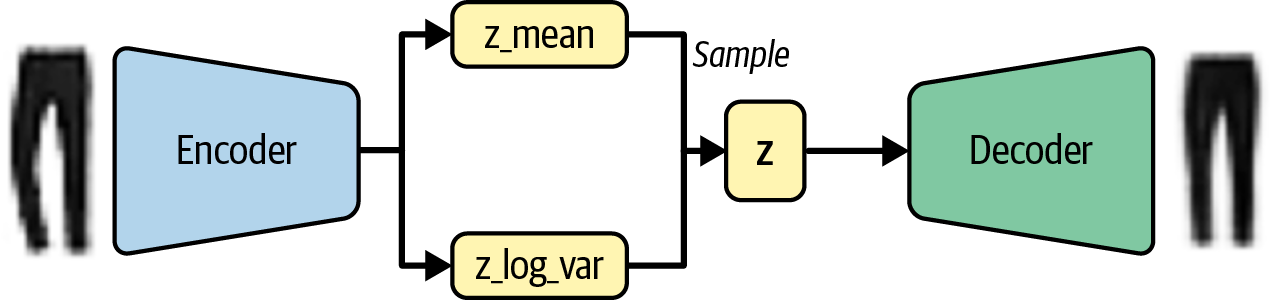


In an autoencoder, each image is mapped directly to one point in the latent space. In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in the latent space
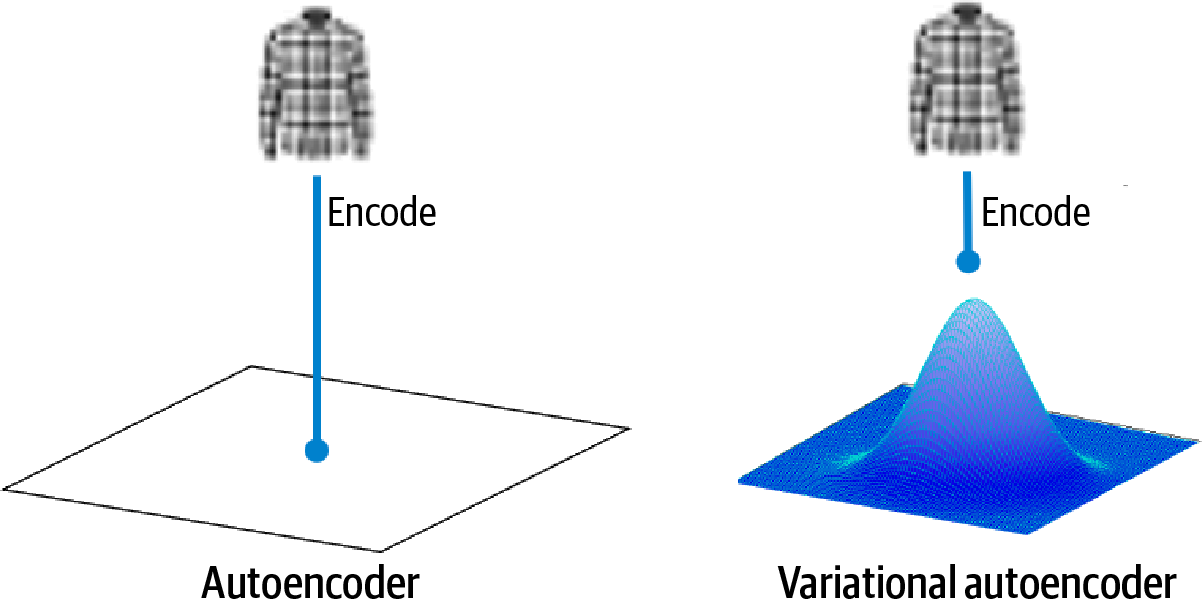

### SAMPLING LAYER

A Sampling layer will allow us to sample from the distribution defined by z_mean and z_log_var

In [9]:
class Sampling(layers.Layer):
    '''
    A Sampling layer will handle the sampling of z from a normal distribution with parameters defined by z_mean and z_log_var.
    This is useful as we want to apply a transformation to a tensor that isn’t already included in an abstract realisation.
    '''    
    
    def call(self, inputs):
        '''
        Call method,which describes how a tensor is transformed by the layer.
        '''
        z_mean, z_log_var = inputs
        # Get number of samples per one call
        batch = tf.shape(z_mean)[0]
        # Get latent space dimensionality
        dim = tf.shape(z_mean)[1]
        # Generate random noise from the variance N(0,1), it will the same dims as a latent z_mean
        epsilon = K.random_normal(shape=(batch, dim))

        # Calculate new selection
        # z = μ + σ ⋅ ϵ
        # μ=z_mean
        # σ=exp⁡(0.5⋅z_log_var)
        # ϵ - taking the exponential ensures that the variance(выборка) is positive
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [22]:
encoder_input = layers.Input(
    shape=(32,32,3),
    name='encoder_input'
)

x= layers.Conv2D(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(encoder_input) 
# ==> Output 
#     T: 32,32,128
#     P: (3x3x3)x128 +128=3584

# We use batch normalization layers after each convolutional layer to stabilize training
x= layers.BatchNormalization()(x) # ==> 2x128
x= layers.LeakyReLU()(x)

x= layers.Conv2D(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(x)
# ==> Output 
#     T: 16,16,128
#     P: (3x3x128)x128 + 128=147584

x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(x)
# ==> Output 
#     T: 8,8,128
#     P: (3x3x128)x128 + 128=147584


x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(x)
# ==> Output 
#     T: 4,4,128
#     P: (3x3x128)x128 + 128=147584


x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

# <== Input shape 4,4,128
shape_befoure_flattening = K.int_shape(x)[1:]

x= layers.Flatten()(x)
# ==> Output shape 4x4x128=2048

# We shall be using a latent space with 200 dimensions instead of 2. Since faces are much more complex than the Fashion-MNIST images, 
# we increase the dimensionality of the latent space so that the network can encode a satisfactory amount of detail from the images.
z_mean= layers.Dense(200, name='z_mean')(x)
# ==> Output shape 200
z_log_var= layers.Dense(200, name='z_log_var')(x)
# ==> Output shape 200
z= Sampling()([z_mean, z_log_var])

In [23]:
# Instead of connecting the Flatten layer directly to the 2D latent space, we connect it to layers z_mean and z_log_var.

encoder= models.Model(
    encoder_input,
    [
        z_mean,
        z_log_var,
        z
    ],
    name='encoder'
)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │      3,584 │ encoder_input[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │    147,584 │ leaky_re_lu_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 128) │    147,584 │ leaky_re_lu_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 2, 2, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ leaky_re_lu_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    102,600 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    102,600 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 200)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 653,584 (2.49 MB)

 Trainable params: 652,560 (2.49 MB)

 Non-trainable params: 1,024 (4.00 KB)

## DECODER

**CONVOLUTIONAL TRANSPOSE LAYERS**

For more theory ub this subject open my autoencoders notebook

In [24]:
# Decoder gets input vector from the encoder. shape=200
decoder_input= layers.Input(
    shape=(200,),
    name='decoder_input'
)

#  Turn vector of 2 elemnts into a flat vector 
x= layers.Dense(
    np.prod(shape_befoure_flattening) # shape_befoure_flattening=4x4x128
)(decoder_input)
# ==> Output = np.prod(4x4x4128) = 2048

x= layers.BatchNormalization()(x) # 2x2048=4096
x= layers.LeakyReLU()(x)

# Reshape vector into a Tensor
# # Restore Vector from the latent space into the 3d Tensor
x= layers.Reshape(shape_befoure_flattening)(x) # Turn vector of 2048 elements back to 3-rank tensor 4x4x128

x= layers.Conv2DTranspose(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(x)
# Output ==> 8,8,128

x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2DTranspose(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(x)
# Output ==> 16,16,128

x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2DTranspose(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(x)
# Output ==> 32,32,128

x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2DTranspose(
    128,
    kernel_size=3,
    strides=2,
    padding='same'
)(x)
# Output ==> 64,64,128

x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

decoder_output= layers.Conv2DTranspose(
    3,
    kernel_size=3,
    strides=1,
    activation='sigmoid',
    padding='same'
)(x)


In [25]:
decoder = models.Model(
    decoder_input,
    decoder_output
)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 4, 4, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 32, 32, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,803 (2.67 MB)

 Trainable params: 698,755 (2.67 MB)

 Non-trainable params: 2,048 (8.00 KB)

## VAE

Loss function
In a VAE, we want to measure how much our normal distribution with parameters z_mean and z_log_var differs from a standard normal distribution.

$$
D_{KL} \left[ N(\mu, \sigma) \parallel N(0, 1) \right] = - \frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
$$

In python this formula looks like:
``` python
kl_loss = -0.5 * sum(1 + z_log_var - z_mean ^ 2 - exp(z_log_var))
```

In [26]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

        # TensorBoard log initialization
        # Logs will be initialized once when constructuior is called and will be reused during trainning
        #current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        #self.train_log_dir = './logs/gradient_tape/' + current_time + '/train'
        #self.test_log_dir = './logs/gradient_tape/' + current_time + '/test'
        #self.train_summary_writer = tf.summary.create_file_writer(self.train_log_dir)
        #self.test_summary_writer = tf.summary.create_file_writer(self.test_log_dir)

    #def on_epoch_begin(self, epoch, logs=None):
    #    self.total_loss_tracker.reset_states()
    #    self.reconstruction_loss_tracker.reset_states()
    #    self.kl_loss_tracker.reset_states()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # z_mean: The mean of the latent distribution.
        # z_log_var: The log variance of the latent distribution.
        # z: The sampled latent vector (using the reparameterization trick, where z = z_mean + exp(0.5 * z_log_var) * epsilon).
        z_mean, z_log_var, z = encoder(inputs)
        # The decoder takes the latent vector z and attempts to reconstruct the original input.
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            # This passes the input data through the model (i.e., calls the call method).
            z_mean, z_log_var, reconstruction = self(data, training=True)
            # measure how well the decoder can reconstruct the input. In our case, the Mean Squared Error (MSE) is used as the loss function, and it's scaled by a factor of 2000
            reconstruction_loss = tf.reduce_mean(
                2000 * losses.mse(data, reconstruction)
            )
            # KL divergence loss, which penalizes the difference between the learned latent distribution and the prior (often a standard Gaussian).             
            kl_loss = tf.reduce_mean(
                # Reduce the sum of terms that compare the latent distribution (z_mean, z_log_var) with a standard normal distribution.
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            # The total loss is the sum of the reconstruction loss and the KL loss, which will be minimized during training
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Write logs for TensorBoard
        # Log save is linked to theoptimizer iterations self.optimizer.iterations this allows us to analyze training dynamics
        #with self.train_summary_writer.as_default():
        #    tf.summary.scalar('total_loss', total_loss, step=self.optimizer.iterations)
        #    tf.summary.scalar('reconstruction_loss', reconstruction_loss, step=self.optimizer.iterations)
         #   tf.summary.scalar('kl_loss', kl_loss, step=self.optimizer.iterations)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
    # This is the validation step, analogous to train_step, but without updating weights or computing gradients.
    def test_step(self, data):
        # If the data is a tuple (common in validation, where labels and inputs may be passed together), only the input data is used
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            2000 * losses.mse(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [27]:
vae=VAE(
    encoder,
    decoder
)

# COMPILE MODEL

**CHOOSING THE LOSS FUNCTION**

Optimizing for RMSE means that your generated output will be symmetrically distributed around the average pixel values (because an overestimation is penalized equivalently to an underestimation). On the other hand, binary cross-entropy loss is asymmetrical—it penalizes errors toward the extremes more heavily than errors toward the center. For example, if the true pixel value is high (say 0.7), then generating a pixel with value 0.8 is penalized more heavily than generating a pixel with value 0.6. If the true pixel value is low (say 0.3), then generating a pixel with value 0.2 is penalized more heavily than generating a pixel with value 0.4. This has the effect of binary cross-entropy loss producing slightly blurrier images than RMSE loss (as it tends to push predictions toward 0.5), but sometimes this is desirable as RMSE can lead to obviously pixelized edges.

In [28]:
optimizer= optimizers.Adam(learning_rate=5e-4)
vae.compile(optimizer=optimizer)


# TRAIN MODEL

In [29]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img= num_img
        self.latent_dim= latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors= tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )

        generated_images= self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            img= utils.array_to_img(generated_images[i])
            img.save('./logs/images/generated_img%03d_%d.png' % (epoch,i))

In [30]:
model_checkpoint_callback= callbacks.ModelCheckpoint(
    filepath='./checkpoint.keras',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0
)
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback= callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

2024-09-29 19:30:56.621108: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-29 19:30:56.621148: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-09-29 19:30:56.621175: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-09-29 19:30:56.621181: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-09-29 19:30:56.621184: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-09-29 19:30:56.621188: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-09-29 19:30:56.621549: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131]

In [31]:
%%time

vae.fit(
    train,
    epochs=10,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(
            num_img=10,
            latent_dim=200
        )
    ]
)

Epoch 1/10


I0000 00:00:1727598662.136414   63288 service.cc:145] XLA service 0x7f2e880861f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727598662.136509   63288 service.cc:153]   StreamExecutor device (0): NVIDIA T1200 Laptop GPU, Compute Capability 7.5
2024-09-29 19:31:02.316759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 19:31:03.190003: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   1/1583 ━━━━━━━━━━━━━━━━━━━━ 5:05:56 12s/step - kl_loss: 0.1431 - loss: 190.6859 - reconstruction_loss: 190.5428

I0000 00:00:1727598669.769584   63288 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-09-29 19:31:09.956217: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-29 19:31:09.956264: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-09-29 19:31:09.956299: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-09-29 19:31:09.956303: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-09-29 19:31:09.956306: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-09-29 19:31:09.956311: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subs

   5/1583 ━━━━━━━━━━━━━━━━━━━━ 1:39 63ms/step - kl_loss: 0.0762 - loss: 187.7041 - reconstruction_loss: 187.6279

2024-09-29 19:31:10.005243: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-09-29 19:31:10.016556: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2024-09-29 19:31:10.016633: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-09-29 19:31:10.016641: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2024-09-29 19:31:10.021990: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-09-29 19:31:10.022078: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-09-29 19:31:10.022088: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:540]  GpuT

1583/1583 ━━━━━━━━━━━━━━━━━━━━ 172s 101ms/step - kl_loss: 12.6167 - loss: 97.5126 - reconstruction_loss: 84.8958
Epoch 2/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 169s 107ms/step - kl_loss: 15.9757 - loss: 67.4119 - reconstruction_loss: 51.4362
Epoch 3/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 166s 105ms/step - kl_loss: 16.5308 - loss: 65.0135 - reconstruction_loss: 48.4827
Epoch 4/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 166s 104ms/step - kl_loss: 16.8413 - loss: 64.0850 - reconstruction_loss: 47.2437
Epoch 5/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 170s 107ms/step - kl_loss: 17.2042 - loss: 63.4211 - reconstruction_loss: 46.2169
Epoch 6/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 172s 109ms/step - kl_loss: 17.3484 - loss: 63.1291 - reconstruction_loss: 45.7807
Epoch 7/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 170s 108ms/step - kl_loss: 17.4059 - loss: 62.8503 - reconstruction_loss: 45.4444
Epoch 8/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 165s 104ms/step - kl_loss: 17.4742 - loss: 62.6731 - reconstruction_loss: 45.1990
Epoch 9/10
1583/158

**[26-09-2024]**

- Epoch 1/10
  
  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 267s 167ms/step - kl_loss: 18.2911 - loss: 62.7919 - reconstruction_loss: 44.5008
- Epoch 2/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 242s 153ms/step - kl_loss: 18.3030 - loss: 62.6459 - reconstruction_loss: 44.3429
- Epoch 3/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 411s 259ms/step - kl_loss: 18.3187 - loss: 62.4910 - reconstruction_loss: 44.1723
- Epoch 4/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 482s 304ms/step - kl_loss: 18.3296 - loss: 62.4017 - reconstruction_loss: 44.0721
- Epoch 5/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 804s 508ms/step - kl_loss: 18.3151 - loss: 62.2833 - reconstruction_loss: 43.9682
- Epoch 6/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 804s 508ms/step - kl_loss: 18.3362 - loss: 62.2273 - reconstruction_loss: 43.8910
- Epoch 7/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 804s 508ms/step - kl_loss: 18.3033 - loss: 62.1414 - reconstruction_loss: 43.8381
- Epoch 8/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 803s 507ms/step - kl_loss: 18.3425 - loss: 62.0595 - reconstruction_loss: 43.7170
- Epoch 9/10

  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 803s 507ms/step - kl_loss: 18.3255 - loss: 62.0144 - reconstruction_loss: 43.6889
- Epoch 10/10
  1583/1583 ━━━━━━━━━━━━━━━━━━━━ 630s 361ms/step - kl_loss: 18.3438 - loss: 61.9651 - reconstruction_loss: 43.6213

In [32]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


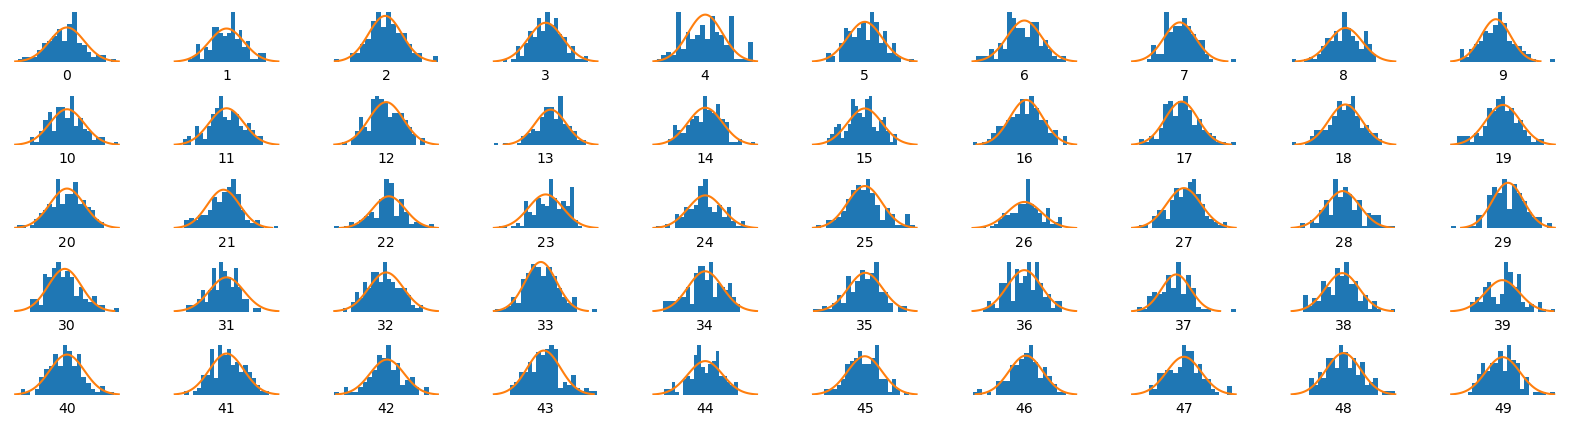

In [33]:
_,_,z= vae.encoder.predict(example_images)
x= np.linspace(-3,3,100)

fig= plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax= fig.add_subplot(5,10,i+1)   
    ax.hist(z[:,i], density=True, bins=20)
    ax.axis("off")
    
    ax.text(
        0.5,-0.35,str(i),fontsize=10,ha='center',transform=ax.transAxes
    )  
    ax.plot(x,norm.pdf(x))

plt.show()

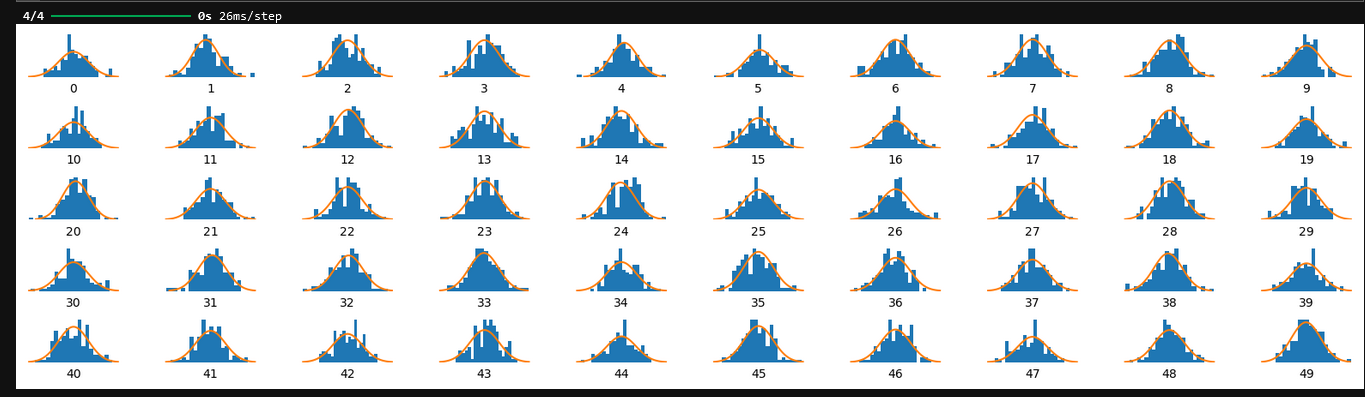

**SUMMARY**

There aren’t any distributions that stand out as being significantly different from the standard normal.

# RECONSTRUCT IMAGES

In [34]:
batches_to_predict= 1
example_images= np.array(
    list(train.take(batches_to_predict).get_single_element())
)

In [35]:
# Create autoencoder predictions and display
z_mean,z_log_var, reconstructions= vae.predict(example_images)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


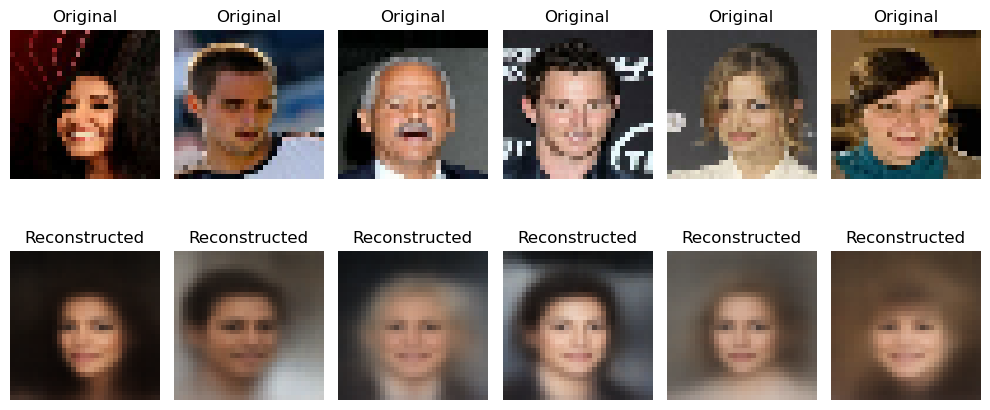

In [36]:
display_original_and_reconstructed(example_images, reconstructions, n=6)

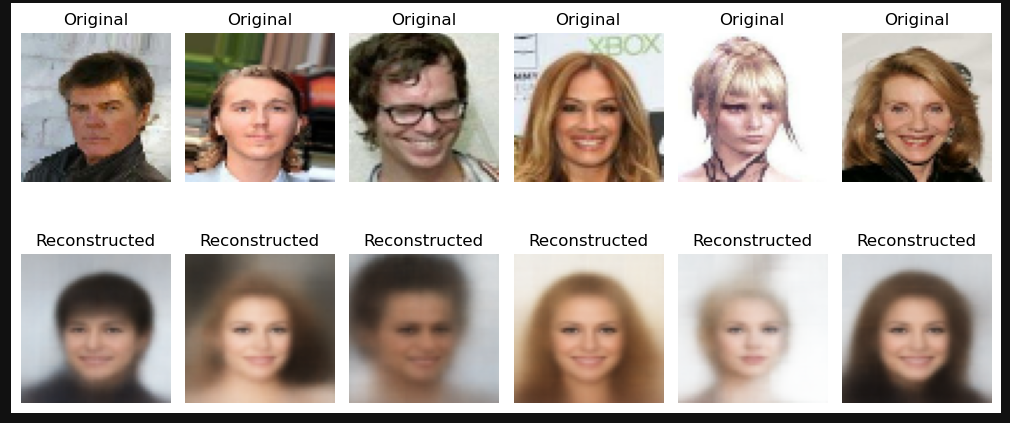

# GENERATE NEW FACES

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


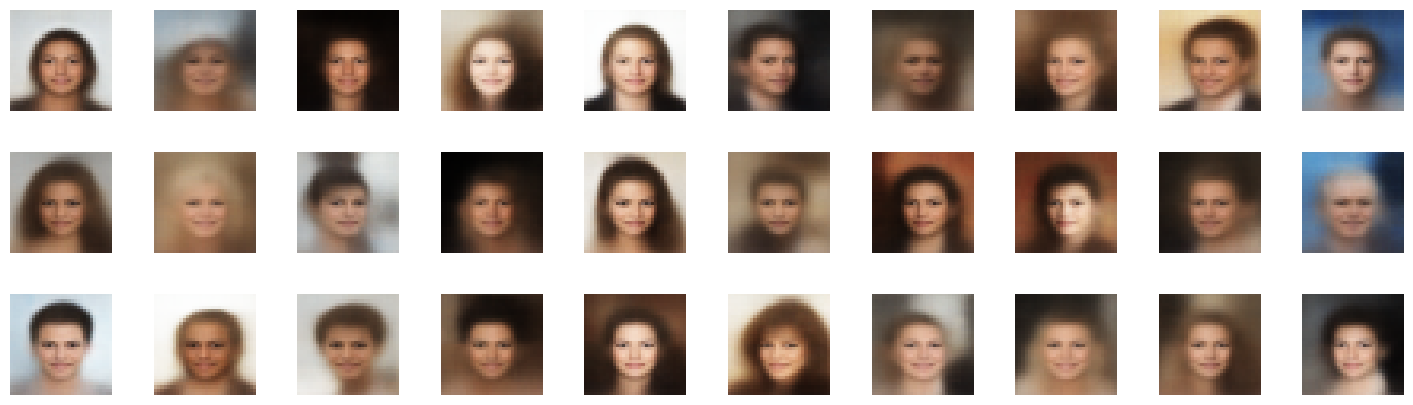

In [37]:
# Sample points from in the latent space, from the standard normal distribution
# It is going to be a 3 rows by 10 images generated from 200 dim latent space
grid_width, grid_height=(10,3)
z_sample= np.random.normal(size=(grid_width * grid_height, 200))

# Decode sample points
reconstructions= decoder.predict(z_sample)

# Draw a plot of decoded images
fig= plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax= fig.add_subplot(grid_height, grid_width, i+1)
    ax.axis('off')
    ax.imshow(reconstructions[i,:,:])

# MANIPULATE IMAGES

In [38]:
file_id = "0B7EVK8r0v71pblRyaVFSWGxPY0U"
file_path = "./celebA/list_attr_celeba.csv"
#download_file_from_google_drive(file_id, file_path)

In [39]:
attributes= pd.read_csv('./celebA/list_attr_celeba.csv')

In [40]:
attributes.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [42]:
%%time

# Load face data with label attached
LABEL= 'Eyeglasses'
labeled_test= utils.image_dataset_from_directory(
    './celebA/img_align_celeba/',
    labels=attributes[LABEL].tolist(),
    color_mode='rgb',
    image_size=(32,32),
    batch_size=128,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear'
)

labeled= labeled_test.map(lambda x,y: (preprocess(x),y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.
Cause: could not parse the source code of <function <lambda> at 0x7f2f74a19a80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f2f74a19a80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 13.8 s, sys: 19.8 s, total: 33.6 s
Wall time: 7min 45s


In [43]:
attribute_vec= get_vector_from_label(labeled,vae,200,LABEL)

label: Eyeglasses
images: pos move: neg move: distance: 𝛥 distance
6    : 5.742000102996826    : 1.4459999799728394    : 5.913000106811523    : 5.913
14    : 4.310999870300293    : 0.9449999928474426    : 4.150000095367432    : -1.7630000114440918
24    : 2.5139999389648438    : 0.5389999747276306    : 3.381999969482422    : -0.7680000066757202
29    : 1.2619999647140503    : 0.3720000088214874    : 3.0959999561309814    : -0.28700000047683716
36    : 1.184000015258789    : 0.3019999861717224    : 2.765000104904175    : -0.3310000002384186
44    : 1.0360000133514404    : 0.24300000071525574    : 2.572999954223633    : -0.19200000166893005
51    : 0.8100000023841858    : 0.18799999356269836    : 2.3380000591278076    : -0.23499999940395355
57    : 0.6389999985694885    : 0.19200000166893005    : 2.2230000495910645    : -0.11500000208616257
61    : 0.4749999940395355    : 0.15199999511241913    : 2.131999969482422    : -0.09099999815225601
68    : 0.5870000123977661    : 0.15199999511241

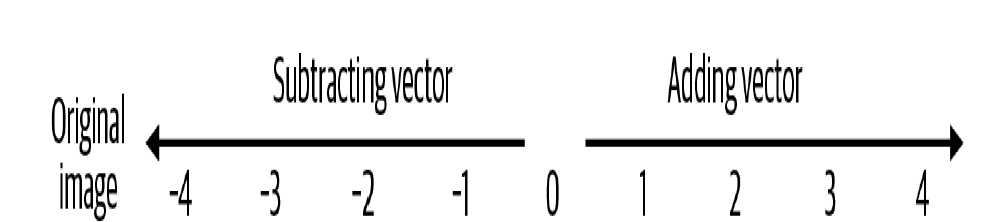

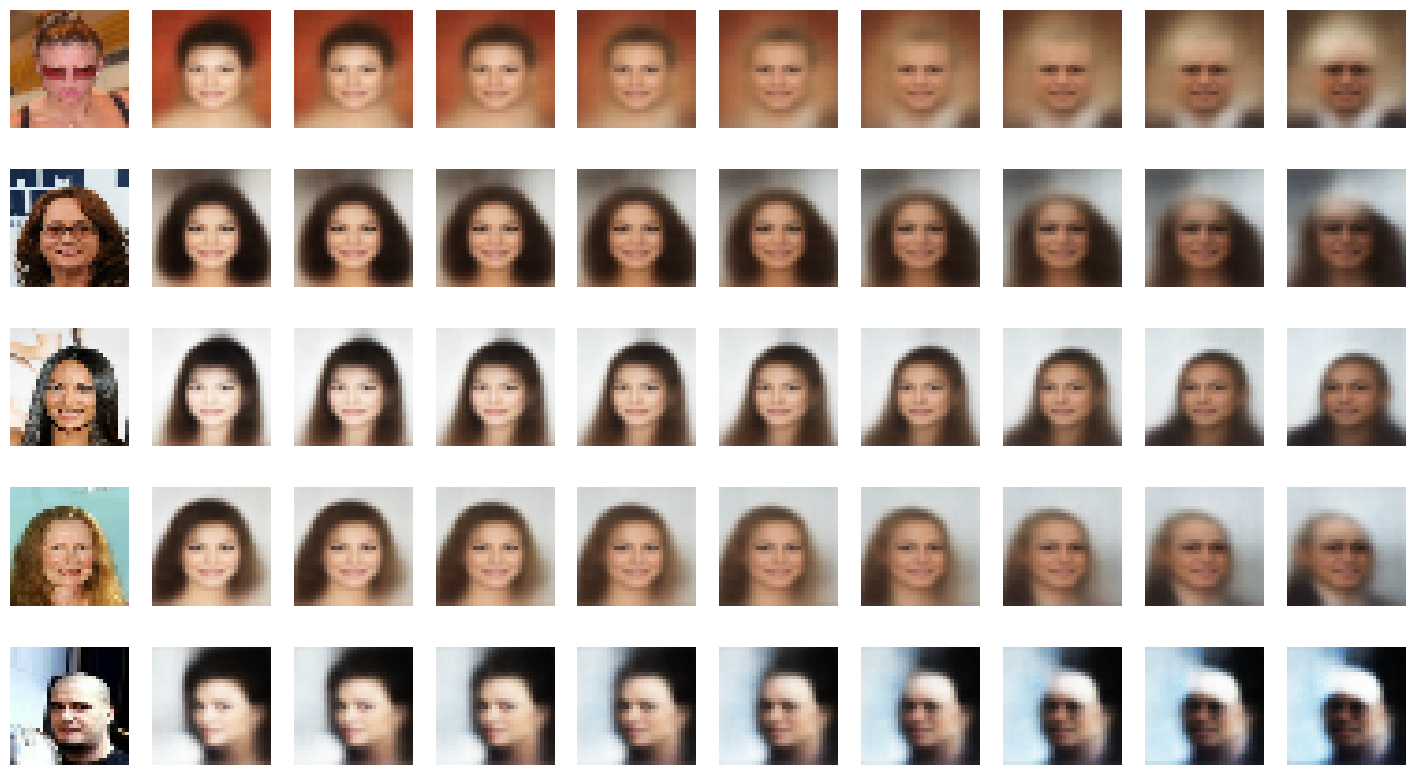

In [44]:
add_vector_to_images(labeled, vae, attribute_vec)

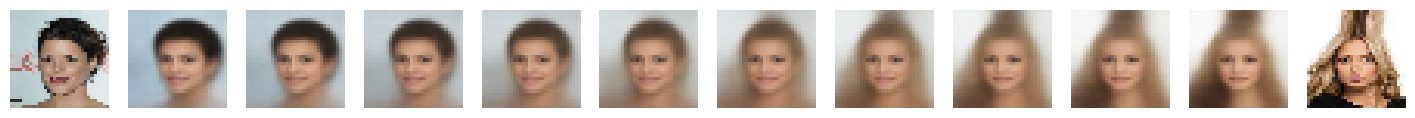

In [48]:
morph_faces(labeled, vae)

**References**

1. [Generative Deep Learning, 2nd Edition](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/): David Foster's book from which has become an inspiration of this notebook.
2. [David Foster](https://github.com/davidADSP): GitHub page
3. [David Foster (Keynote) - Generative Deep Learning -Key To Unlocking Artificial General Intelligence?](https://www.youtube.com/watch?v=rHLf78CmNmQ): David's video session at Youtube regarding some key concepts has written in his book
4. [Animated AI](https://www.youtube.com/@animatedai): Youtube channel with amazing visualizations of how exactly convolution is work.
5. [Make Your Own Neural Network](https://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html): Article explains convolution and T-convolution
6. [Tensorbard Tutorial Blog by Neptune.AI](https://neptune.ai/blog/tensorboard-tutorial)